Problem statement: GCTO has developed and deployed a ML model to predict the LOS for admission in EAI. The prediction will be triggered once the clinical note has been changed or updated. To get the highest accuracy, clinician should refer the latest prediction based on the most updated clinical note.

Datasource: EPIC
Time: 1/1/2024 to 4/4/2024

Aim:To validate and analyze the pattern , descrepancy and potential factor that affect prediction outcome. 

In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [213]:
df = pd.read_csv("LOS_eLOS.csv")
df.head()

,Dummy_PATIENT_ID,Dummy_BILL_ID,BIRTH_DATE,SEX,SEX.1,HOSP_ADMSN_TIME,HOSP_DISCH_TIME,MEAS_VALUE,RECORDED_TIME,ENTRY_TIME
0,8.435241e+09,4218863908,20/04/1935,NaN,Male,01/01/2024 10:44,12/01/2024 9:34,9,01/01/2024 13:57,01/01/2024 13:58
1,8.435241e+09,4218863908,20/04/1935,NaN,Male,01/01/2024 10:44,12/01/2024 9:34,10,01/01/2024 14:41,01/01/2024 14:41
2,8.435241e+09,4218863908,20/04/1935,NaN,Male,01/01/2024 10:44,12/01/2024 9:34,10,01/01/2024 15:03,01/01/2024 15:04
3,6.313729e+09,1626349315,03/03/1953,NaN,Female,01/01/2024 10:09,03/01/2024 14:20,4,01/01/2024 14:30,01/01/2024 14:30
4,8.070266e+09,1402760992,12/11/1968,NaN,Male,01/01/2024 11:52,04/01/2024 13:58,2,01/01/2024 16:42,01/01/2024 16:42


In [214]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5374 entries, 0 to 5373
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dummy_PATIENT_ID  5325 non-null   float64
 1   Dummy_BILL_ID     5374 non-null   int64  
 2   BIRTH_DATE        5374 non-null   object 
 3   SEX               0 non-null      float64
 4   SEX.1             5374 non-null   object 
 5   HOSP_ADMSN_TIME   5374 non-null   object 
 6   HOSP_DISCH_TIME   5374 non-null   object 
 7   MEAS_VALUE        5374 non-null   int64  
 8   RECORDED_TIME     5374 non-null   object 
 9   ENTRY_TIME        5374 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 420.0+ KB


(5374, 10)

In [215]:
df.describe()

,Dummy_PATIENT_ID,Dummy_BILL_ID,SEX,MEAS_VALUE
count,5.325000e+03,5.374000e+03,0.0,5374.000000
mean,5.122917e+09,4.784003e+09,NaN,5.569967
std,2.830316e+09,2.902304e+09,NaN,2.658530
min,1.225175e+07,1.309373e+07,NaN,0.000000
25%,2.749799e+09,2.232432e+09,NaN,4.000000
50%,5.221654e+09,4.736277e+09,NaN,5.000000
75%,7.440391e+09,7.235237e+09,NaN,7.000000
max,9.993029e+09,9.996097e+09,NaN,24.000000



The raw dataset contains of 5374 rows and 10 columns . The average expected LOS is between 5.57days. The maximum days is 24.


# Data Wrangling

In [216]:
# checking for duplicated value
df.duplicated().sum()

0

In [217]:
# checking for missing value
df.isnull().sum() 

Dummy_PATIENT_ID      49
Dummy_BILL_ID          0
BIRTH_DATE             0
SEX                 5374
SEX.1                  0
HOSP_ADMSN_TIME        0
HOSP_DISCH_TIME        0
MEAS_VALUE             0
RECORDED_TIME          0
ENTRY_TIME             0
dtype: int64

Lets drop the 49 missing values in Patient_ID ( >1%) and SEX column does not contain any values.

In [218]:
# check # of patients
df["Dummy_PATIENT_ID"].nunique()

1395

In [219]:
# drop the SEX 
df = df.drop('SEX', axis = 1)

#rename columns name
df = df.rename(columns = {"Dummy_PATIENT_ID":"PATIENT_ID", "Dummy_BILL_ID":"BILL_ID","SEX.1":"SEX","MEAS_VALUE":"ELOS"})
df.head()

,PATIENT_ID,BILL_ID,BIRTH_DATE,SEX,HOSP_ADMSN_TIME,HOSP_DISCH_TIME,ELOS,RECORDED_TIME,ENTRY_TIME
0,8.435241e+09,4218863908,20/04/1935,Male,01/01/2024 10:44,12/01/2024 9:34,9,01/01/2024 13:57,01/01/2024 13:58
1,8.435241e+09,4218863908,20/04/1935,Male,01/01/2024 10:44,12/01/2024 9:34,10,01/01/2024 14:41,01/01/2024 14:41
2,8.435241e+09,4218863908,20/04/1935,Male,01/01/2024 10:44,12/01/2024 9:34,10,01/01/2024 15:03,01/01/2024 15:04
3,6.313729e+09,1626349315,03/03/1953,Female,01/01/2024 10:09,03/01/2024 14:20,4,01/01/2024 14:30,01/01/2024 14:30
4,8.070266e+09,1402760992,12/11/1968,Male,01/01/2024 11:52,04/01/2024 13:58,2,01/01/2024 16:42,01/01/2024 16:42


In [220]:
# covert datatype
df["PATIENT_ID"] = df["PATIENT_ID"].astype(str)
df["PATIENT_ID"] = df["PATIENT_ID"].replace("\.0$","", regex = True) 
df["PATIENT_ID"].value_counts() # 49 missing values


nan           49
9005825802    30
6514429945    22
9522205516    22
4944678123    21
              ..
7414606020     1
5671661545     1
5078172410     1
9830045746     1
2972652563     1
Name: PATIENT_ID, Length: 1396, dtype: int64

In [221]:
# drop the missing values of patientID
print("missing Patient_ID :", (df['PATIENT_ID'] == 'nan').sum())

df = df[df['PATIENT_ID']!= "nan"]
df.shape

missing Patient_ID : 49


(5325, 9)

In [222]:
# covert datatype
df["BIRTH_DATE"]= pd.to_datetime(df["BIRTH_DATE"], format = "%d/%m/%Y")
df[["HOSP_ADMSN_TIME", "HOSP_DISCH_TIME","RECORDED_TIME","ENTRY_TIME"]] = df[["HOSP_ADMSN_TIME", "HOSP_DISCH_TIME","RECORDED_TIME","ENTRY_TIME"]].apply(pd.to_datetime, format = "%d/%m/%Y %H:%M")


In [223]:
# create Month column 
Adm_Month = df["HOSP_ADMSN_TIME"].dt.to_period("M")
df.insert(7, "Adm_Month", Adm_Month )

In [224]:
month_map = {
    '2024-01': 'Jan',
    '2024-02': 'Feb',
    '2024-03': 'Mar',
    '2024-04': 'Apr'}

df['Adm_Month'] = df['Adm_Month'].astype(str).map(month_map)

In [225]:
# Convert datetime to date-only format
df["HOSP_ADMSN_TIME"] = df["HOSP_ADMSN_TIME"].dt.date
df["HOSP_DISCH_TIME"] = df["HOSP_DISCH_TIME"].dt.date

In [226]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5325 entries, 0 to 5373
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   PATIENT_ID       5325 non-null   object        
 1   BILL_ID          5325 non-null   int64         
 2   BIRTH_DATE       5325 non-null   datetime64[ns]
 3   SEX              5325 non-null   object        
 4   HOSP_ADMSN_TIME  5325 non-null   object        
 5   HOSP_DISCH_TIME  5325 non-null   object        
 6   ELOS             5325 non-null   int64         
 7   Adm_Month        5325 non-null   object        
 8   RECORDED_TIME    5325 non-null   datetime64[ns]
 9   ENTRY_TIME       5325 non-null   datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(5)
memory usage: 457.6+ KB


In [227]:
# calculate the age
from datetime import datetime

current = datetime.now()

def cal_age(birthdate):
    age = current.year - birthdate.year-((current.month, current.day)<(birthdate.month, birthdate.day))
    return age

# create "age" column and place behind 
df.insert(3, "AGE", df["BIRTH_DATE"].apply(cal_age))
df

,PATIENT_ID,BILL_ID,BIRTH_DATE,AGE,SEX,HOSP_ADMSN_TIME,HOSP_DISCH_TIME,ELOS,Adm_Month,RECORDED_TIME,ENTRY_TIME
0,8435240811,4218863908,1935-04-20,89,Male,2024-01-01,2024-01-12,9,Jan,2024-01-01 13:57:00,2024-01-01 13:58:00
1,8435240811,4218863908,1935-04-20,89,Male,2024-01-01,2024-01-12,10,Jan,2024-01-01 14:41:00,2024-01-01 14:41:00
2,8435240811,4218863908,1935-04-20,89,Male,2024-01-01,2024-01-12,10,Jan,2024-01-01 15:03:00,2024-01-01 15:04:00
3,6313729203,1626349315,1953-03-03,71,Female,2024-01-01,2024-01-03,4,Jan,2024-01-01 14:30:00,2024-01-01 14:30:00
4,8070265503,1402760992,1968-11-12,55,Male,2024-01-01,2024-01-04,2,Jan,2024-01-01 16:42:00,2024-01-01 16:42:00
...,...,...,...,...,...,...,...,...,...,...,...
5369,9993029310,9455312842,1968-07-23,55,Female,2024-04-01,2024-04-04,5,Apr,2024-04-02 15:59:00,2024-04-02 15:59:00
5370,9993029310,9455312842,1968-07-23,55,Female,2024-04-01,2024-04-04,5,Apr,2024-04-02 16:04:00,2024-04-02 16:04:00
5371,9993029310,9455312842,1968-07-23,55,Female,2024-04-01,2024-04-04,5,Apr,2024-04-02 16:10:00,2024-04-02 16:10:00
5372,9993029310,9455312842,1968-07-23,55,Female,2024-04-01,2024-04-04,5,Apr,2024-04-02 16:16:00,2024-04-02 16:17:00


In [228]:
# create age group

# Define age bins and corresponding labels
bins = [18, 29, 49, 69, 89, 110]  # bin edges
labels = ['18-29', '30-49', '50-69', '70-89', '90 or older']

age_group = pd.cut(df['AGE'], bins=bins, labels=labels, right=True, include_lowest=True)

df.insert(4, 'AGE_group', age_group)


In [229]:
# calculate the acutal Lenght of stay( ALOS)

LOS = (df["HOSP_DISCH_TIME"]-df["HOSP_ADMSN_TIME"]).dt.days

df.insert(8,"ALOS", LOS)
df

,PATIENT_ID,BILL_ID,BIRTH_DATE,AGE,AGE_group,SEX,HOSP_ADMSN_TIME,HOSP_DISCH_TIME,ALOS,ELOS,Adm_Month,RECORDED_TIME,ENTRY_TIME
0,8435240811,4218863908,1935-04-20,89,70-89,Male,2024-01-01,2024-01-12,11,9,Jan,2024-01-01 13:57:00,2024-01-01 13:58:00
1,8435240811,4218863908,1935-04-20,89,70-89,Male,2024-01-01,2024-01-12,11,10,Jan,2024-01-01 14:41:00,2024-01-01 14:41:00
2,8435240811,4218863908,1935-04-20,89,70-89,Male,2024-01-01,2024-01-12,11,10,Jan,2024-01-01 15:03:00,2024-01-01 15:04:00
3,6313729203,1626349315,1953-03-03,71,70-89,Female,2024-01-01,2024-01-03,2,4,Jan,2024-01-01 14:30:00,2024-01-01 14:30:00
4,8070265503,1402760992,1968-11-12,55,50-69,Male,2024-01-01,2024-01-04,3,2,Jan,2024-01-01 16:42:00,2024-01-01 16:42:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5369,9993029310,9455312842,1968-07-23,55,50-69,Female,2024-04-01,2024-04-04,3,5,Apr,2024-04-02 15:59:00,2024-04-02 15:59:00
5370,9993029310,9455312842,1968-07-23,55,50-69,Female,2024-04-01,2024-04-04,3,5,Apr,2024-04-02 16:04:00,2024-04-02 16:04:00
5371,9993029310,9455312842,1968-07-23,55,50-69,Female,2024-04-01,2024-04-04,3,5,Apr,2024-04-02 16:10:00,2024-04-02 16:10:00
5372,9993029310,9455312842,1968-07-23,55,50-69,Female,2024-04-01,2024-04-04,3,5,Apr,2024-04-02 16:16:00,2024-04-02 16:17:00


In [230]:
# discrepancy between MEAS_VALUE and ALOS
disc_days = df["ELOS"]-df["ALOS"]
df.insert(10, "Discrepancy_days", disc_days )

In [231]:
df

,PATIENT_ID,BILL_ID,BIRTH_DATE,AGE,AGE_group,SEX,HOSP_ADMSN_TIME,HOSP_DISCH_TIME,ALOS,ELOS,Discrepancy_days,Adm_Month,RECORDED_TIME,ENTRY_TIME
0,8435240811,4218863908,1935-04-20,89,70-89,Male,2024-01-01,2024-01-12,11,9,-2,Jan,2024-01-01 13:57:00,2024-01-01 13:58:00
1,8435240811,4218863908,1935-04-20,89,70-89,Male,2024-01-01,2024-01-12,11,10,-1,Jan,2024-01-01 14:41:00,2024-01-01 14:41:00
2,8435240811,4218863908,1935-04-20,89,70-89,Male,2024-01-01,2024-01-12,11,10,-1,Jan,2024-01-01 15:03:00,2024-01-01 15:04:00
3,6313729203,1626349315,1953-03-03,71,70-89,Female,2024-01-01,2024-01-03,2,4,2,Jan,2024-01-01 14:30:00,2024-01-01 14:30:00
4,8070265503,1402760992,1968-11-12,55,50-69,Male,2024-01-01,2024-01-04,3,2,-1,Jan,2024-01-01 16:42:00,2024-01-01 16:42:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5369,9993029310,9455312842,1968-07-23,55,50-69,Female,2024-04-01,2024-04-04,3,5,2,Apr,2024-04-02 15:59:00,2024-04-02 15:59:00
5370,9993029310,9455312842,1968-07-23,55,50-69,Female,2024-04-01,2024-04-04,3,5,2,Apr,2024-04-02 16:04:00,2024-04-02 16:04:00
5371,9993029310,9455312842,1968-07-23,55,50-69,Female,2024-04-01,2024-04-04,3,5,2,Apr,2024-04-02 16:10:00,2024-04-02 16:10:00
5372,9993029310,9455312842,1968-07-23,55,50-69,Female,2024-04-01,2024-04-04,3,5,2,Apr,2024-04-02 16:16:00,2024-04-02 16:17:00


In [232]:
df["Discrepancy_days"].describe()

count    5325.000000
mean        0.133333
std         6.192433
min       -67.000000
25%        -1.000000
50%         1.000000
75%         3.000000
max        18.000000
Name: Discrepancy_days, dtype: float64

In [233]:
# create a new row for categorise the prediction
def cat_pred(LOS):
    if LOS > 0:
        return "Overestimated"
    elif LOS < 0:
        return "Underestimated"
    else:
        return "Accurate"

df.insert(11, "prediction",df["Discrepancy_days"].apply(cat_pred))


Lets do feature creatation :
1. Age/ Age_group
2. ALOS
3. Discrepancy days (ELOS-ALOS)
4. prediction ( accuracy/ over/ underestimated)
5. Adm_Month
6. Readmission Frequency (at readmission section)
7. Readmission interval

In order to get the latest ELOS measurement, first I groupby bill_id to ensure the analysis is based on the admission visit not patient level. In each admission, filtered and keep the latest entry time of clincial note. 

For better understand the readmission interval,I grouped the patient_id, in each group of ID, the  "HOSP_DISCH_TIME" from the previous row will be shifted down to next row in "pre_disch"column. For the first row of each group, since there is no previous row, the value in "pre_disch" will be NaN.


In [234]:
# create a new row with lastest entry time group by bill_id
df["lastest_entry"]= df.groupby("BILL_ID")["ENTRY_TIME"].transform("max")

# keep the lastest entry time and drop recorded and lastest_entry columns
lastest_df = df[df["ENTRY_TIME"]== df["lastest_entry"]]
lastest_df= lastest_df.drop(["RECORDED_TIME", "lastest_entry"],axis = 1)
lastest_df

,PATIENT_ID,BILL_ID,BIRTH_DATE,AGE,AGE_group,SEX,HOSP_ADMSN_TIME,HOSP_DISCH_TIME,ALOS,ELOS,Discrepancy_days,prediction,Adm_Month,ENTRY_TIME
2,8435240811,4218863908,1935-04-20,89,70-89,Male,2024-01-01,2024-01-12,11,10,-1,Underestimated,Jan,2024-01-01 15:04:00
3,6313729203,1626349315,1953-03-03,71,70-89,Female,2024-01-01,2024-01-03,2,4,2,Overestimated,Jan,2024-01-01 14:30:00
8,8070265503,1402760992,1968-11-12,55,50-69,Male,2024-01-01,2024-01-04,3,2,-1,Underestimated,Jan,2024-01-01 17:15:00
9,9680839341,957281989,1963-05-25,61,50-69,Male,2024-01-01,2024-01-03,2,3,1,Overestimated,Jan,2024-01-01 17:52:00
11,544432713,1661142741,1970-10-28,53,50-69,Female,2024-01-01,2024-01-02,1,3,2,Overestimated,Jan,2024-01-01 21:25:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5354,4278317744,8961012675,1944-01-06,80,70-89,Female,2024-04-01,2024-04-03,2,7,5,Overestimated,Apr,2024-04-01 23:12:00
5361,6968047681,6931311291,1948-02-25,76,70-89,Female,2024-04-01,2024-04-05,4,7,3,Overestimated,Apr,2024-04-02 02:25:00
5367,4728530036,2213905469,1946-12-02,77,70-89,Male,2024-04-01,2024-04-06,5,3,-2,Underestimated,Apr,2024-04-02 18:40:00
5368,2825371681,446224642,1941-07-30,82,70-89,Female,2024-04-01,2024-04-03,2,11,9,Overestimated,Apr,2024-04-02 03:16:00


In [235]:
# create interval duration for readmission

lastest_df= lastest_df.sort_values(by=["PATIENT_ID", "HOSP_ADMSN_TIME"])

lastest_df["pre_disch"] = lastest_df.groupby("PATIENT_ID")["HOSP_DISCH_TIME"].shift()
lastest_df.insert(14, "readm_interval", (lastest_df["HOSP_ADMSN_TIME"]-lastest_df["pre_disch"]).dt.days)



In [236]:
lastest_df.describe()

,BILL_ID,AGE,ALOS,ELOS,Discrepancy_days,readm_interval
count,1.498000e+03,1498.000000,1498.000000,1498.000000,1498.000000,103.000000
mean,4.902529e+09,64.889853,5.097463,5.496662,0.399199,19.786408
std,2.882840e+09,18.280689,5.444428,2.735316,5.368783,20.176501
min,1.309373e+07,18.000000,0.000000,0.000000,-61.000000,0.000000
25%,2.413624e+09,54.000000,2.000000,4.000000,-1.000000,4.000000
50%,4.840952e+09,68.000000,4.000000,5.000000,1.000000,13.000000
75%,7.372490e+09,77.000000,6.000000,7.000000,3.000000,26.500000
max,9.996097e+09,103.000000,74.000000,24.000000,18.000000,81.000000


In [237]:
lastest_df[lastest_df["ALOS"] == 0]

,PATIENT_ID,BILL_ID,BIRTH_DATE,AGE,AGE_group,SEX,HOSP_ADMSN_TIME,HOSP_DISCH_TIME,ALOS,ELOS,Discrepancy_days,prediction,Adm_Month,ENTRY_TIME,readm_interval,pre_disch
814,2482338936,4345741420,1990-10-25,33,30-49,Male,2024-01-16,2024-01-16,0,4,4,Overestimated,Jan,2024-01-16 11:09:00,NaN,NaN
5110,2936054255,1388859423,1984-01-15,40,30-49,Male,2024-03-29,2024-03-29,0,13,13,Overestimated,Mar,2024-03-29 06:05:00,10.0,2024-03-19
3057,3959374453,3417754451,1946-09-07,77,70-89,Male,2024-02-22,2024-02-22,0,4,4,Overestimated,Feb,2024-02-22 17:51:00,9.0,2024-02-13
4117,4666414990,4634549144,1964-04-12,60,50-69,Male,2024-03-12,2024-03-12,0,8,8,Overestimated,Mar,2024-03-12 13:35:00,NaN,NaN
4924,6537880379,2232432449,1999-10-07,24,18-29,Male,2024-03-28,2024-03-28,0,1,1,Overestimated,Mar,2024-03-28 10:41:00,NaN,NaN
2440,6995615172,4730895335,1949-07-09,75,70-89,Female,2024-02-12,2024-02-12,0,11,11,Overestimated,Feb,2024-02-12 05:51:00,25.0,2024-01-18
2004,7112521384,3617265929,1959-11-06,64,50-69,Female,2024-02-05,2024-02-05,0,10,10,Overestimated,Feb,2024-02-05 16:09:00,NaN,NaN
2523,7261294922,4337444627,1946-12-16,77,70-89,Male,2024-02-13,2024-02-13,0,3,3,Overestimated,Feb,2024-02-13 10:59:00,NaN,NaN


In [238]:
lastest_df[lastest_df["readm_interval"] == 0]

,PATIENT_ID,BILL_ID,BIRTH_DATE,AGE,AGE_group,SEX,HOSP_ADMSN_TIME,HOSP_DISCH_TIME,ALOS,ELOS,Discrepancy_days,prediction,Adm_Month,ENTRY_TIME,readm_interval,pre_disch
3237,2809111258,7112913184,1951-08-26,72,70-89,Female,2024-02-26,2024-02-29,3,3,0,Accurate,Feb,2024-02-26 14:15:00,0.0,2024-02-26
3783,7390615902,6404907226,1941-12-28,82,70-89,Male,2024-03-05,2024-03-18,13,7,-6,Underestimated,Mar,2024-03-06 00:21:00,0.0,2024-03-05
4971,8683227747,4934583171,1973-12-10,50,50-69,Male,2024-03-27,2024-04-06,10,3,-7,Underestimated,Mar,2024-03-27 16:45:00,0.0,2024-03-27
4187,883446708,4959854660,2005-11-14,18,18-29,Male,2024-03-13,2024-03-15,2,2,0,Accurate,Mar,2024-03-13 17:01:00,0.0,2024-03-13


I noticed that there has min values are 0 in ALOS and readmission interval.Lets explore more

there are 8 admissions were same day discharged.
Q:Does the dateset included daysurgery cases or any one day procedure cases?

There were 4 patients who discharged and readmitted on the same day. 
Q:Would it possible patient discharged and readmitted under different speciality? or discharged from ward and readmitted through A&E?

# EDA

In this section, I will explore and visualize underlying relationships in the data. 
I am  interested at looking how features in this dataset affect prediction . 

First, let's look at the demographic in the dataset

In [239]:
sns.set_theme()

Total # of patients from Jan-4th April: 1395
Total # of admission from Jan-4th April: 1498


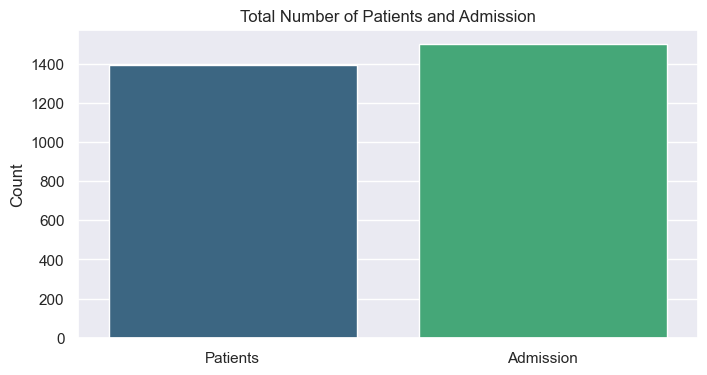

In [240]:
total_pt =lastest_df["PATIENT_ID"].nunique()
total_visit = lastest_df["BILL_ID"].nunique()


print("Total # of patients from Jan-4th April:", lastest_df["PATIENT_ID"].nunique())
print("Total # of admission from Jan-4th April:", lastest_df["BILL_ID"].nunique())

# plot the graph
pt_visit_df = {"Category":["Patients", "Admission"], "Count":[total_pt, total_visit]}

plt.figure(figsize = (8,4))
sns.barplot(x = "Category", y = "Count", data =pt_visit_df, palette = "viridis")
plt.ylabel("Count")
plt.title("Total Number of Patients and Admission")
plt.show()

# CohortDemographic (Patient-Level) 

SEX
Female    761
Male      634
dtype: int64


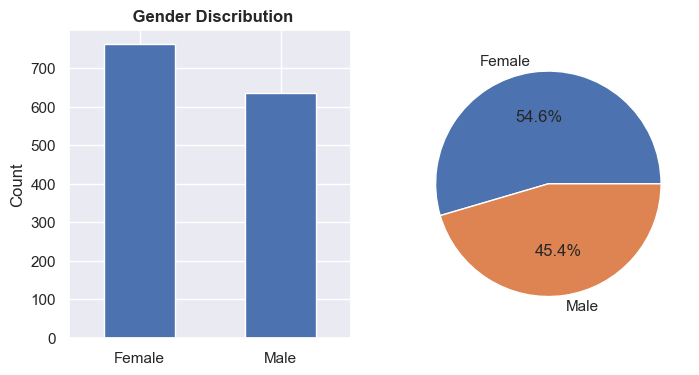

In [241]:
sex_distribution = lastest_df.drop_duplicates(subset = ["PATIENT_ID", "SEX"]).groupby("SEX").size()
sex_per = sex_distribution/lastest_df["PATIENT_ID"].nunique()*100
sex_per.round(2)
print(sex_distribution)

# plot the chart
sex_distribution_1 = lastest_df.drop_duplicates(subset = ["PATIENT_ID", "SEX"])
sex_distribution_1= sex_distribution_1["SEX"].value_counts()

plt.figure(figsize = (8,4))
plt.subplot(1,2,1)
sex_distribution_1.plot(kind = "bar")
plt.ylabel("Count")
plt.xticks(rotation = 0)
plt.title(" Gender Discribution", fontsize=12, weight='bold')

plt.subplot(1,2,2)
plt.pie(sex_per, labels = sex_per.index,autopct = "%1.1f%%" )
plt.show()


70-89          569
50-69          459
30-49          204
18-29           83
90 or older     80
Name: AGE_group, dtype: int64


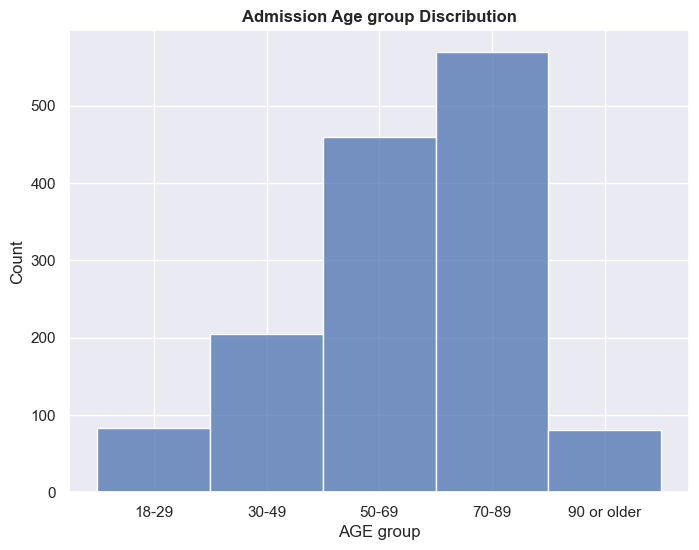

In [242]:
Age_distribution = lastest_df.drop_duplicates(subset = ["PATIENT_ID", "AGE"])
print(Age_distribution["AGE_group"].value_counts())

# plot a graph
plt.figure(figsize = (8,6))
sns.histplot(data = Age_distribution, x = "AGE_group")
plt.xlabel("AGE group")
plt.ylabel("Count")
plt.title("Admission Age group Discribution", fontsize=12, weight='bold')
plt.show()


# Prediction Accuracy and discrepancy rate 

Total number of Prediction Accuracy cases: 165 ; percent: 11.01 %
Total number of Prediction Discrepancy cases: 1333 ; percent: 88.99 %
Total number of Overestimated cases among Discrepancy cases : 914 percent: 68.57%
Total number of UnderOverestimated cases among Discrepancy cases : 419 percent: 31.43%


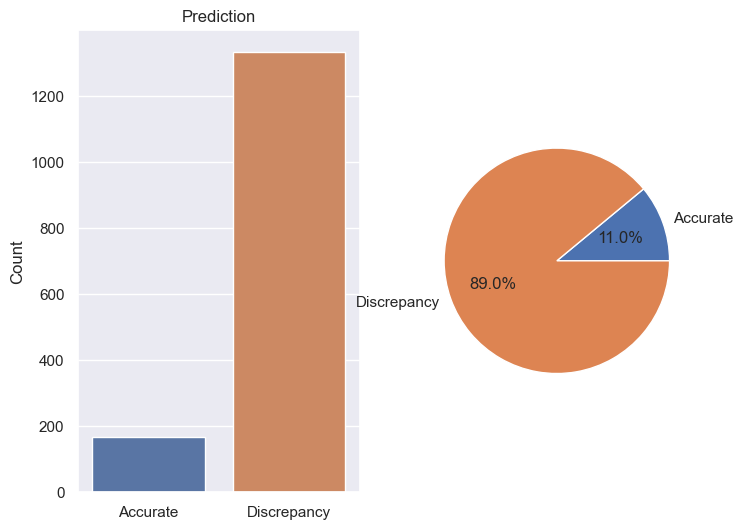

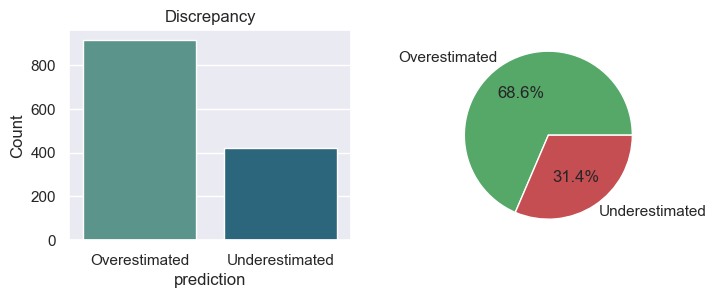

In [243]:
acc= (lastest_df["prediction"] == "Accurate").sum()
discr = (lastest_df["prediction"] != "Accurate").sum()
acc_rate = acc/lastest_df["BILL_ID"].nunique()*100
discr_rate = discr/lastest_df["BILL_ID"].nunique()*100
over= (lastest_df["prediction"] == "Overestimated").sum()
under = (lastest_df["prediction"] == "Underestimated").sum()



print("Total number of Prediction Accuracy cases:", acc, ";", "percent:", acc_rate.round(2), "%")
print("Total number of Prediction Discrepancy cases:", discr, ";", "percent:", discr_rate.round(2), "%")
print("Total number of Overestimated cases among Discrepancy cases :", over, "percent:", "{:.2f}%".format((over/discr)*100))
print("Total number of UnderOverestimated cases among Discrepancy cases :", under, "percent:", "{:.2f}%".format((under/discr)*100))

# create a dataset for accurate and discrepancy
disc_acc_df = {"Prediction":["Accurate", "Discrepancy"], "Count":[acc,discr]}
disc_acc_rate_df = {"Prediction":["Accurate", "Discrepancy"], "Count":[acc_rate,discr_rate]}
discr_df = lastest_df[lastest_df["prediction"]!= "Accurate"]
over_under_df = {"Discrepancy":["Overestimated", "Underestimated"], "Count":[over/discr,under/discr]}


plt.figure(figsize = (8,6))
plt.subplot(1,2,1)
sns.barplot(x = "Prediction", y = "Count", data =disc_acc_df)
plt.ylabel("Count")
plt.title("Prediction")

plt.subplot(1,2,2)
plt.pie(disc_acc_rate_df["Count"], labels = disc_acc_rate_df["Prediction"], autopct = "%1.1f%%" )
plt.show()

plt.figure(figsize = (8,6))
plt.subplot(2,2,1)
sns.countplot(data = discr_df, x = "prediction", palette= "crest" )
plt.ylabel("Count")
plt.title("Discrepancy")

plt.subplot(2,2,2)
plt.pie(over_under_df["Count"], labels = over_under_df["Discrepancy"], autopct = "%1.1f%%",colors = "green")
plt.show()

In [244]:
lastest_df["Discrepancy_days"].describe()

count    1498.000000
mean        0.399199
std         5.368783
min       -61.000000
25%        -1.000000
50%         1.000000
75%         3.000000
max        18.000000
Name: Discrepancy_days, dtype: float64

Now, I'm interested to know who are the patients has highest over/underestimated discrepancy days.  

Overestimated:  70y/o male, ALOS was 1 days. To understand why the model predicted a longer stay, further data aggregation is needed, such as patient diagnosis, discharge status (deceased, transferred to nursing home, palliative care), referral source (from A&E?), and comorbidities.

Underestimated: 60y/o female, ALOS 74 days, predicted LOS 13days. In addition to gathering additional data, reviewing clinical notes from that admission may reveal if crucial information was missed, potentially not reflecting the severity of the disease. It’s also important to consider if clinical notes were stored under different specialists' or doctors' accounts.

In [245]:
# largest overestimated days
lastest_df[lastest_df["Discrepancy_days"] == lastest_df["Discrepancy_days"].max()]

,PATIENT_ID,BILL_ID,BIRTH_DATE,AGE,AGE_group,SEX,HOSP_ADMSN_TIME,HOSP_DISCH_TIME,ALOS,ELOS,Discrepancy_days,prediction,Adm_Month,ENTRY_TIME,readm_interval,pre_disch
4399,9934504499,6061104410,1954-01-27,70,70-89,Male,2024-03-16,2024-03-17,1,19,18,Overestimated,Mar,2024-03-16 17:06:00,NaN,NaN


In [246]:
lastest_df["PATIENT_ID"][lastest_df["PATIENT_ID"] == "9934504499"]

4399    9934504499
Name: PATIENT_ID, dtype: object

In [247]:
# largest underestimated days
lastest_df[lastest_df["Discrepancy_days"] == lastest_df["Discrepancy_days"].min()]

,PATIENT_ID,BILL_ID,BIRTH_DATE,AGE,AGE_group,SEX,HOSP_ADMSN_TIME,HOSP_DISCH_TIME,ALOS,ELOS,Discrepancy_days,prediction,Adm_Month,ENTRY_TIME,readm_interval,pre_disch
2298,4501758662,1841157657,1963-11-14,60,50-69,Female,2024-02-09,2024-04-23,74,13,-61,Underestimated,Feb,2024-04-04 00:50:00,NaN,NaN


In [248]:
lastest_df["PATIENT_ID"][lastest_df["PATIENT_ID"] == "4501758662"]

2298    4501758662
Name: PATIENT_ID, dtype: object


Both patients are not readmission record. 

# ALOS and Discrepancy days

In [249]:

# Define age bins and corresponding labels
bins = [0, 3,10, 20, 30, 82 ]  # bin edges
labels = ['0-3', "4-10",'11-20', '21-30', '31 above ']

ALOS_group = pd.cut(lastest_df['ALOS'], bins=bins, labels=labels, right=True, include_lowest=True)

lastest_df.insert(15, 'ALOS_group', ALOS_group)

Text(0, 0.5, 'Frequency')

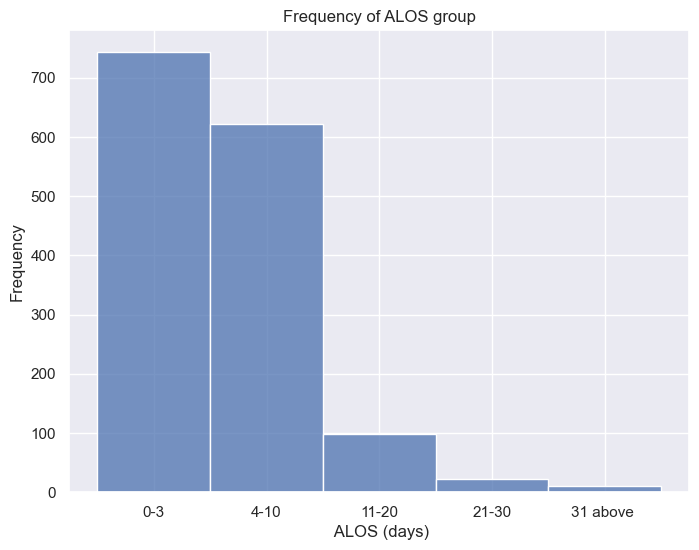

In [250]:
plt.figure(figsize=(8,6))
sns.histplot(data = lastest_df, x = "ALOS_group")
plt.title("Frequency of ALOS group")
plt.xlabel(" ALOS (days)")
plt.ylabel("Frequency")

In [251]:
# sns.histplot(data = lastest_df, x = "Discrepancy_days", color='green')
# plt.ylabel("Frequency")

bins = [-65, -10, -4, -1, 1, 3, 10, 20, 82]
labels = ['-20 above', '-11 to -20','-10 to -4', '-3 to -1', '1-3', '4-10', '11-20', '21 above']

Discrepancy_group = pd.cut(lastest_df['Discrepancy_days'], bins=bins, labels=labels, right=True, include_lowest=True)

lastest_df.insert(16, 'Discrepancy_group', Discrepancy_group)

Text(0.5, 0, 'Discrepancy days')

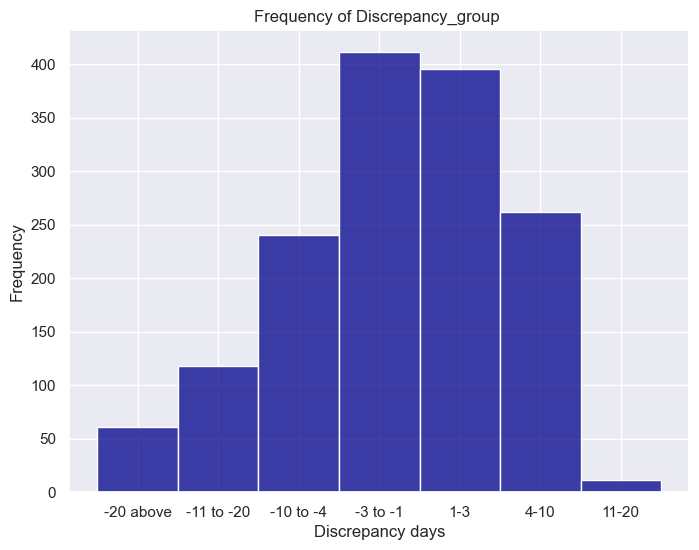

In [252]:
plt.figure(figsize = (8,6))
sns.histplot(data = lastest_df, x = "Discrepancy_group", color='darkblue')
plt.ylabel("Frequency")
plt.title ("Frequency of Discrepancy_group ")
plt.xlabel("Discrepancy days")

In [210]:
# # boxpot
# days_df = lastest_df[["ALOS","Discrepancy_days"]]
# print(days_df.describe())

# f, ax = plt.subplots(figsize=(10, 6))
# sns.boxplot(data = days_df)
# plt.ylabel("days")
# plt.title("ALOS vs Discrepancy days",fontsize=12, weight='bold')
# ax.set(ylim=(-20, 20))
# plt.show()

# Does discrepancy days vary with gender?

[(-20.0, 20.0)]

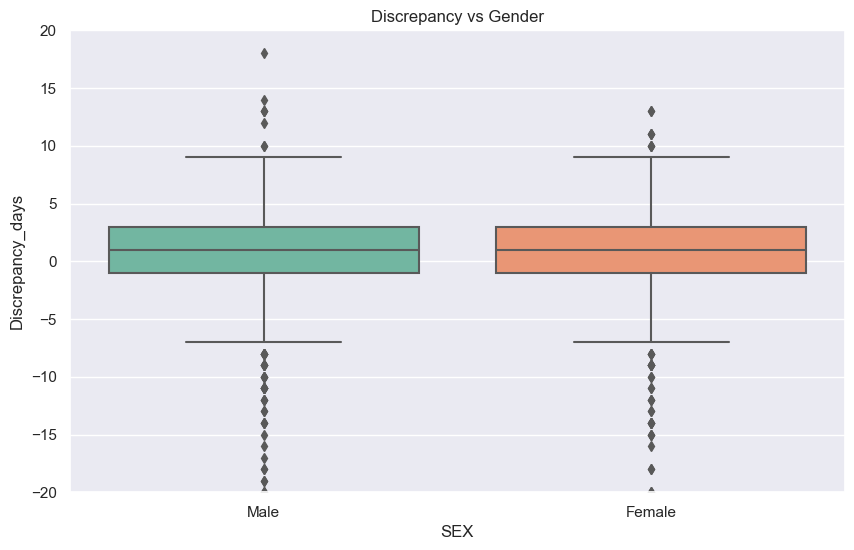

In [40]:
f,ax= plt.subplots(figsize = (10,6))
sns.boxplot(data = lastest_df, x = "SEX", y="Discrepancy_days", palette="Set2")
plt.title("Discrepancy vs Gender")
ax.set(ylim=(-20,20))


# Does discrepancy days vary with age of the patient?

             count      mean       std   min  25%  50%  75%   max
AGE_group                                                        
18-29         83.0  0.879518  2.652185  -5.0 -1.0  1.0  2.0  10.0
30-49        204.0  0.455882  3.747316 -18.0 -1.0  1.0  2.0  12.0
50-69        459.0  0.047930  5.740940 -61.0 -1.0  1.0  2.0  13.0
70-89        569.0  0.562390  5.119356 -43.0 -1.0  1.0  3.0  18.0
90 or older   80.0  0.662500  6.906141 -46.0  0.0  2.0  3.0  11.0


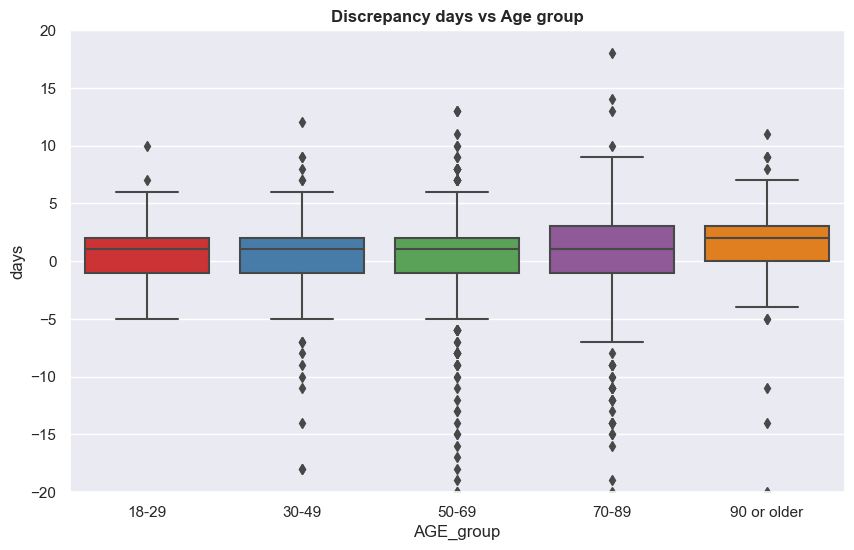

In [41]:
Age_distribution_1 = Age_distribution.groupby('AGE_group')["Discrepancy_days"]
print(Age_distribution_1.describe())

f, ax = plt.subplots(figsize = (10,6))
sns.boxplot(data = Age_distribution, x = "AGE_group", y="Discrepancy_days", palette="Set1")
plt.ylabel("days")
plt.title("Discrepancy days vs Age group",fontsize=12, weight='bold' )
ax.set(ylim=(-20, 20))
plt.show()



In [253]:
# plt.figure(figsize = (8,6))
# sns.histplot(data = lastest_df, x = "AGE_group", hue = "prediction", multiple="dodge", shrink=0.8)
# plt.title( "Prediction vs Age group")

# Does discrepancy days vary with ALOS?

In [43]:
# create readmission interval group

# Define age bins and corresponding labels
bins = [0, 10, 20, 30,40, 82 ]  # bin edges
labels = ['0-10', '11-20', '21-30', '31-40', '41 and above ']

ALOS_group = pd.cut(lastest_df['ALOS'], bins=bins, labels=labels, right=True, include_lowest=True)

lastest_df.insert(15, 'ALOS_group', ALOS_group)

Text(0.5, 0, 'ALOS(days)')

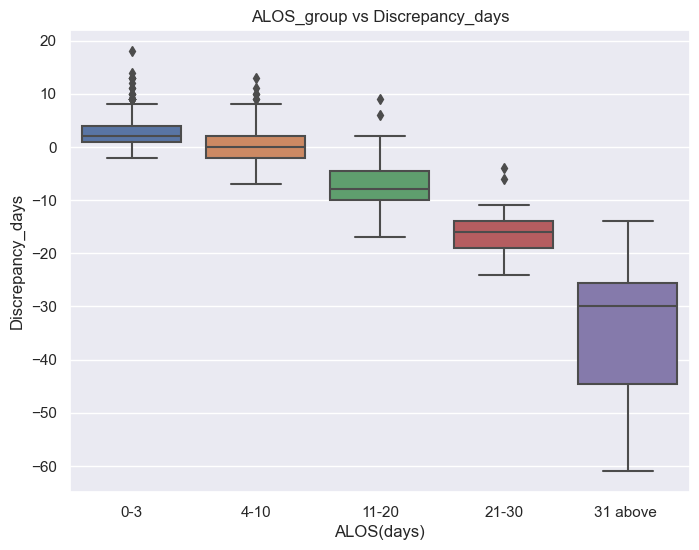

In [180]:
plt.figure(figsize = (8,6))
sns.boxplot(data = lastest_df, x = "ALOS_group", y = "Discrepancy_days" )
plt.title("ALOS_group vs Discrepancy_days")
plt.xlabel("ALOS(days)")

we can see the if patients stay longer that will it tend for model to underestimated LOS if stays more than 10days. for the ALOS group 0-10days, median discrepancy is close to 0 indicating that the predictions are fairly accurate.The interquartile range (IQR) is small, suggesting consistency in the predictions. in ALOS more than 30 days, IQR is larger than other groups which indicating more variability in predictions. As the ALOS increases, the median discrepancy tends to become more negative that the model tends to undeerestimate the length of stay more for patients with longer ALOS. suggest can do fine tuning the model for those longer LOS cases.

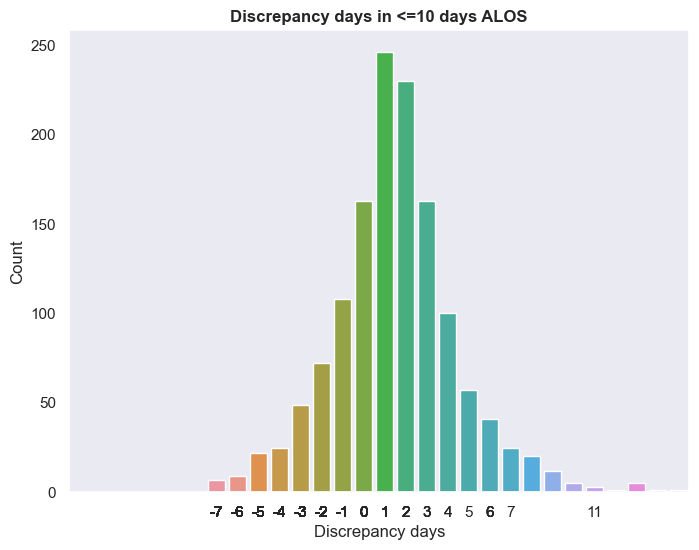

In [182]:
ALOS_zerototen = lastest_df[lastest_df["ALOS_group"].isin(["0-3","4-10"])]

plt.figure(figsize = (8,6))
sns.countplot(data = ALOS_zerototen, x = "Discrepancy_days")
plt.xlabel("Discrepancy days")
plt.ylabel("Count")
plt.title("Discrepancy days in <=10 days ALOS", fontsize=12, weight='bold')
plt.xticks(ALOS_zerototen["Discrepancy_days"])
plt.grid(axis = "y")
plt.show()

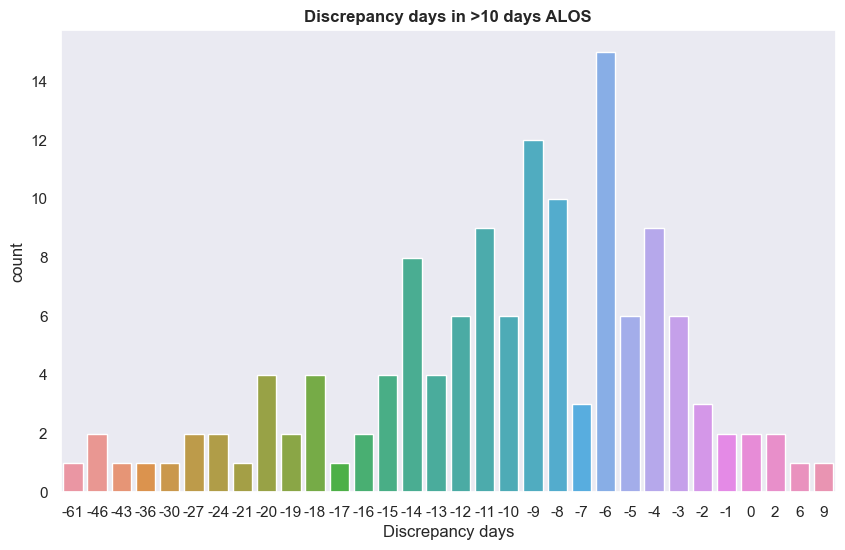

In [183]:
ALOS_morethanten = lastest_df[~lastest_df["ALOS_group"].isin(["0-3","4-10"])]

plt.figure(figsize = (10,6))
sns.countplot(data = ALOS_morethanten, x = "Discrepancy_days")
plt.xlabel("Discrepancy days")
plt.title("Discrepancy days in >10 days ALOS", fontsize=12, weight='bold')
plt.grid(axis = "y")
plt.show()

The majority of discrepancy days are negative, the model tends to underestimate the LOS for patients with ALOS > 10 days.
The most frequent negative discrepancies are around -6, -4, -9, which -6 days being the most common (14 cases).The plot supports the trend observed in the boxplot, where longer ALOS groups tend to have more significant negative discrepancies.The variability and spread of discrepancy days observed in the plot align with the increasing IQR seen in the boxplot for higher ALOS groups.

# Does discrepancy days vary with admission month?

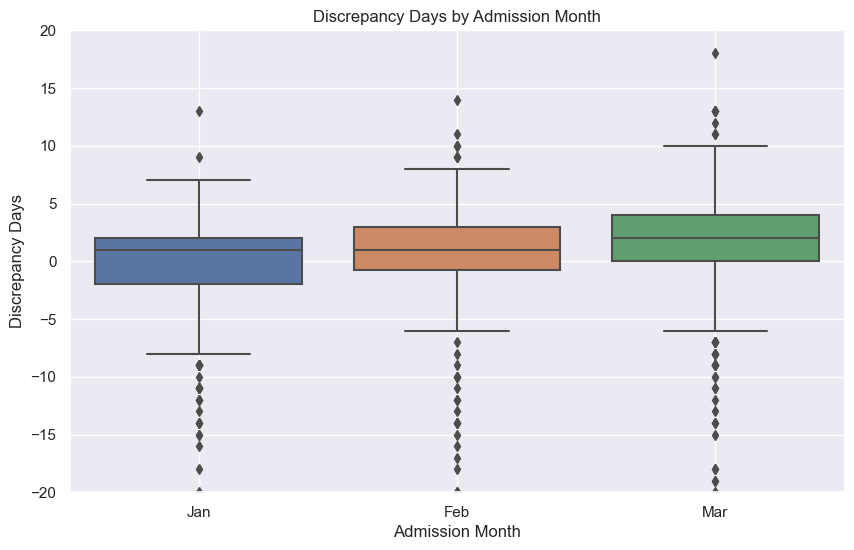

In [254]:
lastest_df["Adm_Month"] = pd.Categorical(lastest_df["Adm_Month"])

average_month = lastest_df.groupby("Adm_Month")[["ALOS","ELOS"]].mean()
mth_order = ["Jan", "Feb", "Mar"]
average_month = average_month.reindex(mth_order)

# plt.figure(figsize = (10,6))
# average_month.plot(kind ="bar")
# plt.xlabel("")
# plt.ylabel("days")
# plt.xticks(rotation = 0)
# plt.title("Average days in ALOS & ELOS by Month", fontsize=12, weight='bold' )

f, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=lastest_df, x="Adm_Month", y="Discrepancy_days", order = ["Jan", "Feb","Mar"])
plt.title('Discrepancy Days by Admission Month')
plt.xlabel('Admission Month')
plt.ylabel('Discrepancy Days')
plt.grid(True)
ax.set(ylim=(-20, 20))
plt.show()



The median discrepancy days are similar from January to March, and the consistent Interquartile Range (IQR) suggests that the prediction model's performance is stable and unaffected by month.

# Does discrepancy days vary with readmission?

In [48]:
# looking for readmission patients


re_admission = lastest_df["PATIENT_ID"][lastest_df["PATIENT_ID"].duplicated()]
re_admission_df = lastest_df[lastest_df["PATIENT_ID"].isin(re_admission)]
re_admission_df["PATIENT_ID"].nunique()

admission_pt = lastest_df["PATIENT_ID"].value_counts()
readmission_pt= admission_pt[admission_pt >1]
sorted_readm = readmission_pt.value_counts().sort_values()

re_admission_num = re_admission_df["PATIENT_ID"].nunique()/ lastest_df["PATIENT_ID"].nunique()
readm_rate = readmission_pt.sum()/lastest_df["PATIENT_ID"].nunique()*100


total_pt_re =re_admission_df["PATIENT_ID"].nunique()
total_visit_re = re_admission_df["BILL_ID"].nunique()


print("Total # of patients from Jan-4th April:", re_admission_df["PATIENT_ID"].nunique())
# print("Total # of admission from Jan-4th April:", re_admission_df["BILL_ID"].nunique())
print("Readmission rate: ", "{:.2f}%".format((re_admission_num)*100))
print("Admission frequency vs patients from Jan-4th April:\n",sorted_readm)

# plot the graph
# pt_visit_re_df = {"Category":["Patients", "Readmission"], "Count":[total_pt_re, total_visit_re]}

# plt.figure(figsize = (8,4))
# sns.barplot(x = "Category", y = "Count", data = pt_visit_re_df, palette = "viridis")
# plt.ylabel("Count")
# plt.title("Total Number of Patients and Readmission")
# plt.show()



Total # of patients from Jan-4th April: 86
Readmission rate:  6.16%
Admission frequency vs patients from Jan-4th April:
 5     1
4     1
3    12
2    72
Name: PATIENT_ID, dtype: int64


In [49]:
# to calculate the frequency of readmission 

fre_readm = re_admission_df["PATIENT_ID"].value_counts().reset_index()
fre_readm.columns= ["PATIENT_ID","Frequency of readmission"]

# merge the freq data
re_admission_df = re_admission_df.merge(fre_readm, on= "PATIENT_ID", how = "left")


In [50]:
# plt.figure(figsize = (10,6))
# sns.countplot(data = re_admission_df, x = "Frequency of readmission")
# plt.title( "Frequency of admission")
# plt.show()


# plt.figure(figsize = (10,6))
# sns.histplot(data = re_admission_df, x = "Frequency of readmission", hue = "SEX", multiple = "dodge", shrink=2)
# plt.xticks(re_admission_df["Frequency of readmission"])
# plt.title( "Frequency of admission vs Gender")
# plt.show()


# plt.figure(figsize = (10,6))
# sns.histplot(data = re_admission_df, x = "Frequency of readmission", hue = "AGE_group", multiple = "dodge", shrink=2)
# plt.xticks(re_admission_df["Frequency of readmission"])
# plt.title( "Frequency of admission vs Age group")
# plt.show()

In [255]:
# f, ax = plt.subplots(figsize=(10, 6))
# sns.boxplot(data=re_admission_df, x="Frequency of readmission", y="Discrepancy_days")
# plt.title('Discrepancy Days vs Frequency of readmission')
# plt.xlabel('Frequency of admssion')
# plt.ylabel('Discrepancy Days')
# plt.grid(True)
# ax.set(ylim=(-20, 20))
# plt.show()


In [52]:
# create readmission interval group

# Define age bins and corresponding labels
bins = [0, 3, 10, 20, 30, 82 ]  # bin edges
labels = ['0-3', '4-10', '11-20', '21-30', '>31 ']

readm_interval_group = pd.cut(re_admission_df['readm_interval'], bins=bins, labels=labels, right=True, include_lowest=True)

re_admission_df.insert(14, 'readm_interval_group', readm_interval_group)


Text(0.5, 1.0, 'Frequency of readmision interval')

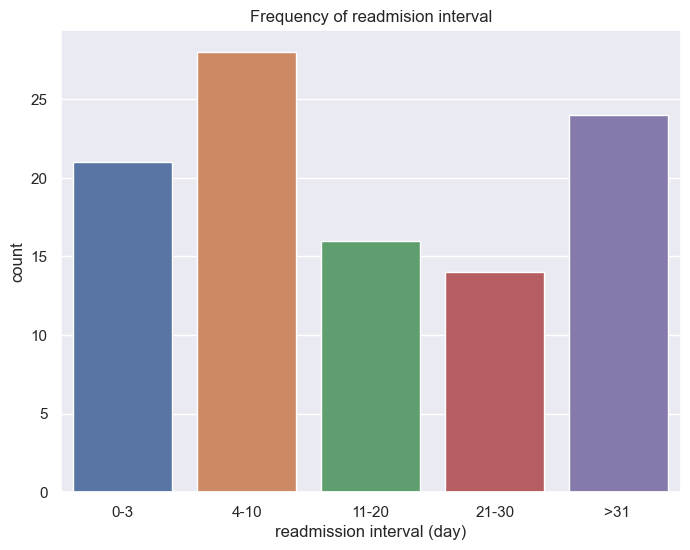

In [262]:
plt.figure(figsize = (8,6))

sns.countplot(data = re_admission_df, x = "readm_interval_group")
plt.xlabel("readmission interval (day)")
plt.title("Frequency of readmision interval")

# plt.subplot(1,2,2)
# sns.countplot(data = re_admission_df, x = "readm_interval_group", hue = "AGE_group", palette= "Set1", width=1)
# plt.ylabel("")
# plt.xlabel("readmission interval (day)")
# plt.show()

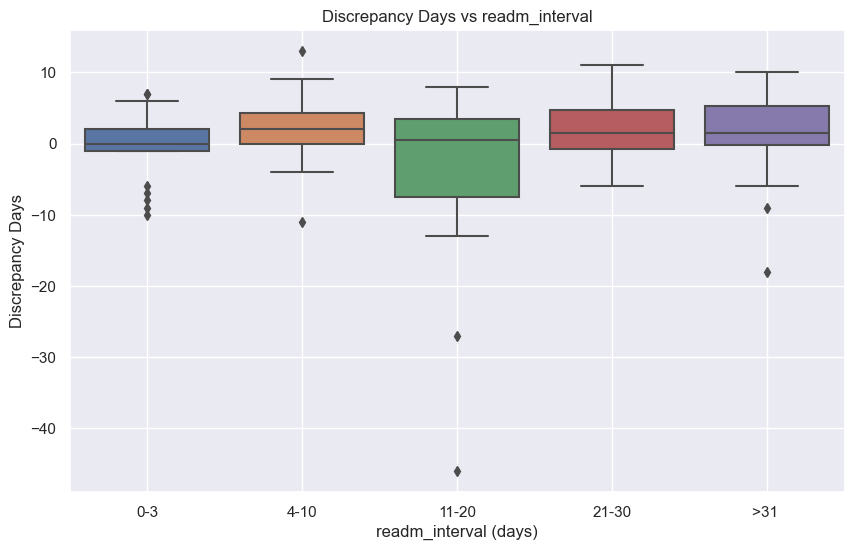

In [54]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=re_admission_df, x="readm_interval_group", y="Discrepancy_days")
plt.title('Discrepancy Days vs readm_interval')
plt.xlabel('readm_interval (days)')
plt.ylabel('Discrepancy Days')
plt.grid(True)
plt.show()

Predictions are generally more accurate for readmission intervals of 0-3 days, .the IQR is narrow in 0-3days group, low variability in predictions. 11-20 days as median is closed to 0.
There is higher spread of the discrepancy days at 1-9 days in middle 50% data and a tendency to underestimate LOS for the 11-20 days readmission interval group.The model should be fine-tuned to reduce underestimation, especially for the 11-20 days readmission interval group.

2 main findings that related to discrepancy days:

    1. ALOS: As the ALOS increases, the median discrepancy tends to become more negative that the model tends to undeerestimate the length of stay more for patients with longer ALOS.more than 10days onwards.There may be factors or complexities in longer hospital stays that the model does not fully capture, leading to a systematic underestimation in these cases.
    
    2.readmission interval: model can prediction well and stable in readmission interval less than 3 days. for readmission within 11-20days, model tend to have higher variability of prediction. The variability suggests that there are factors influencing readmissions within this timeframe that the model struggles to consistently predict. Further investigation into these factors could help improve prediction accuracy.
    
in addition, there are significant number of outliers in this cohort. To address these above findings effectively, further data collection is recommended.  This should include additional information such as patient diagnosis, comorbidities, discharge status, and referral sources. These additional data points could provide insights into why certain cases deviate significantly from the model predictions

Text(0.5, 0, 'ALOS(days)')

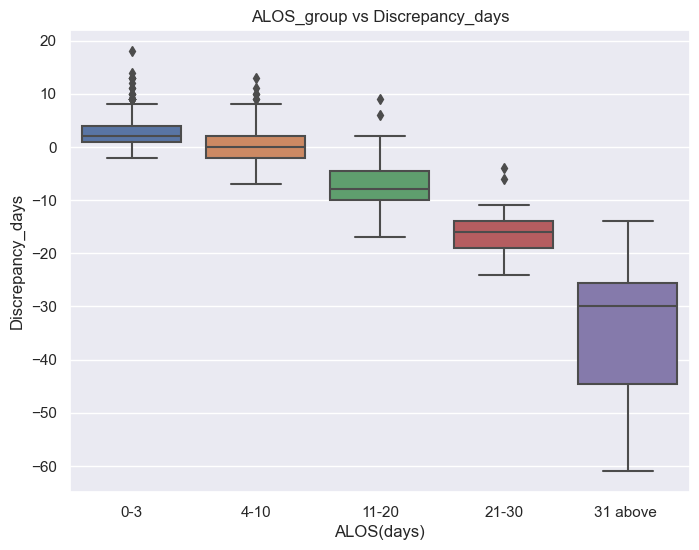

In [263]:
plt.figure(figsize = (8,6))
sns.boxplot(data = lastest_df, x = "ALOS_group", y = "Discrepancy_days" )
plt.title("ALOS_group vs Discrepancy_days")
plt.xlabel("ALOS(days)")